# SPT & TESS Coinciding Flare Observation Plot for Upcoming Proposal

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [3]:
coinciding_flares_df = pd.read_pickle('spt_tess_candidates.pkl')
coinciding_flares_df

,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


In [4]:
hdul = fits.open("spt3g_flare_lightcurves_flare_single_scan.fits")
hdul.info()

Filename: spt3g_flare_lightcurves_flare_single_scan.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     42   111R x 12C   [30A, 30A, 30A, 30A, 30A, PD(18), PD(18), PD(18), PD(18), PD(18), PD(18), PD(18)]   


In [119]:
spt_flare_data = hdul[1].data
spt_ids = spt_flare_data.spt_id.astype(str).split('" "')
spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
spt_flux_95 = spt_flare_data['95_flux']
spt_flux_err_95 = spt_flare_data['95_err']
spt_flux_150 = spt_flare_data['150_flux']
spt_flux_err_150 = spt_flare_data['150_err']
spt_times = spt_flare_data['time']

SPT Flares Dataframe Index: 42
Flare Time: 59131.84358217593
SPOC
exptime: 20.000071625690907
SPT Flares Dataframe Index: 43
Flare Time: 59067.68513527199
QLP
exptime: 600.0058533230913
SPT Flares Dataframe Index: 46
Flare Time: 59068.341974826384
SPOC
exptime: 120.00262312794803
SPT Flares Dataframe Index: 49
Flare Time: 59110.28528935186
SPOC
exptime: 600.0011807394912


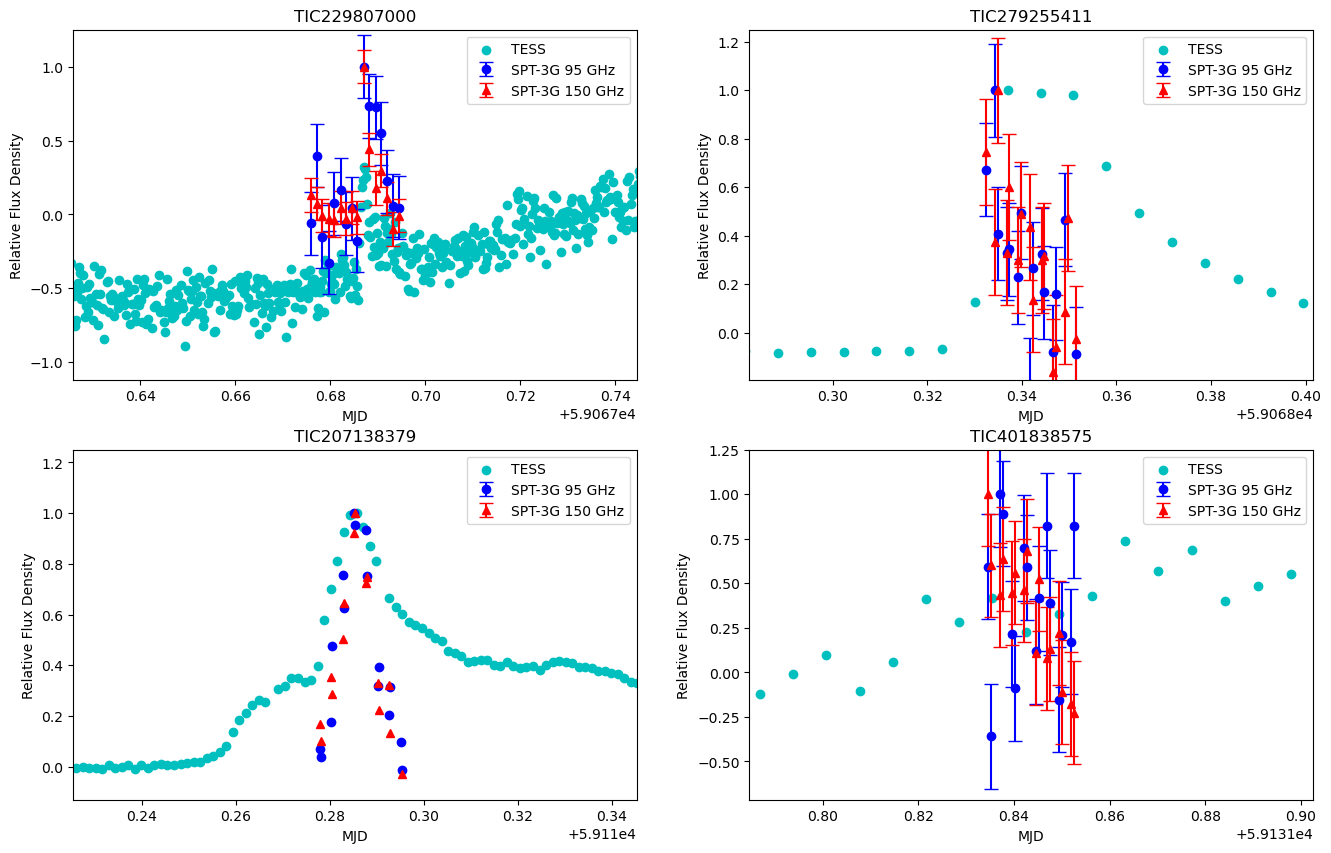

In [171]:
fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

scale_int = { # manually picked to remove impact of other transients within a few days or wierd TESS data processing behavior between observations
    'TIC229807000': 0.75,
    'TIC279255411': 5,
    'TIC207138379': 14,
    'TIC401838575': 4.
}

for i, flare in coinciding_flares_df.iterrows(): 
    spt_id = flare['spt_id']
    TIC = flare['TIC']
    scale_width = scale_int[TIC]
    ax = fig.add_subplot(gs[int(i/2), int(i%2)])

    '''
    SPT quiescent is around 0 so we just scale by max
    '''
    def rel_flux(array):
        return array / np.nanmax(array)

    lc_idx = np.where(spt_ids == spt_id)[0][0]
    print('SPT Flares Dataframe Index:',lc_idx)
    print('Flare Time:',flare_time)
    ax.errorbar(spt_times[lc_idx], rel_flux(spt_flux_95[lc_idx]), yerr= 32 / np.max(spt_flux_95[lc_idx]) * np.ones_like(np.abs(spt_flux_err_95[lc_idx])), fmt='bo', capsize=5, label= 'SPT-3G 95 GHz') #flux error currently hardcoded in as 32 mJy
    ax.errorbar(spt_times[lc_idx], rel_flux(spt_flux_150[lc_idx]), yerr= 32 / np.max(spt_flux_150[lc_idx]) * np.ones_like(np.abs(spt_flux_err_150[lc_idx])), fmt='r^', capsize=5, label= 'SPT-3G 150 GHz') #flux error currently hardcoded in as 32 mJy



    target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
    obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'fast')
    if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'short')
    if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0])
    flare_obs = obj[0].download()
    print(flare_obs.author)
    qual = flare_obs.quality.value
    time = np.array(flare_obs.time.value)
    time = time[qual ==0]
    print("exptime:", (time[1] - time[0])*24*3600)
    sap_flux = np.array(flare_obs.sap_flux.value)
    sap_flux = sap_flux[qual ==0]
    time += 2457000.0 - 2400000.5 - 0.005 # the -0.005 is artificial to line up flare, but idk why its even needed? Data wrong? Conversion seems straightforward

    '''
    Following Guns et al. 2021 TESS flux is mean subtracted and then scaled to the max within some interval (see scale_int above)
    Guns et al. 2021 uses 2 weeks, but these flares have other transients (flares?) or tess processing 'artifacts' within that duration
    '''
    flare_time = np.mean(spt_times[lc_idx])
    flare_region = (time > (flare_time - scale_width)) & (time < (flare_time + scale_width))

    def normed_2week(array):
        mu = np.nanmean(array[flare_region])
        high = np.nanmax(array[flare_region])
        low = np.nanmin(array[flare_region])
        return (array - mu) / (high - mu)

    ax.scatter(time, normed_2week(sap_flux), c= 'c', label= 'TESS')
    
    ax.set_ylabel('Relative Flux Density')
    ax.set_xlabel('MJD')

    # Flare Overlap Interval
    ax.set_xlim(np.min(spt_times[lc_idx]) - 0.05, np.max(spt_times[lc_idx]) + 0.05)
    ax.set_ylim(np.min(normed_2week(sap_flux)) - 0.1,1.25)
    
    # Longer Time Trend View
    # ax.vlines((flare_time - scale_width, flare_time, flare_time + scale_width), 0, 1)
    # ax.set_xlim(np.min(spt_times[lc_idx]) - 2*scale_width, np.max(spt_times[lc_idx]) + 2*scale_width)
    # plot_int_start = np.where((time > (np.min(spt_times[lc_idx]) - 2*scale_width)) & (time < (np.max(spt_times[lc_idx]) + 2*scale_width)))
    # ax.set_ylim(np.min(normed_2week(sap_flux)) - 0.1, np.max(normed_2week(sap_flux)[plot_int_start]) + 0.1)
    
    ax.legend()
    ax.set_title(TIC)

In [46]:
0.005 * 24 * 60

7.199999999999999